## 1. Import the module

In [1]:
import altair as alt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
# Save a vega-lite spec and a PNG blob for each plot in the notebook
alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

# 2. Summary of the data set

### 2.1 Read the data and split the data into 70% train and 30% test set.

In [2]:
df = pd.read_csv(
    "../data/raw/contraceptive.csv",
)
train_df, test_df = train_test_split(df, test_size=0.3, random_state=123)
train_df.head()

,Wife Age,Wife education,Husband education,Number of children ever born,Wife religion,Wife now working?,Husband occupation,Standard-of-living index,Media exposure,Contraceptive method used
834,41,1,4,9,1,1,2,1,0,3
491,40,4,4,6,0,0,1,4,0,2
376,40,3,3,3,1,1,2,2,1,1
250,34,4,4,3,0,1,1,2,0,1
228,47,1,4,8,1,1,3,3,0,1


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1031 entries, 834 to 1389
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   Wife Age                      1031 non-null   int64
 1   Wife education                1031 non-null   int64
 2   Husband education             1031 non-null   int64
 3   Number of children ever born  1031 non-null   int64
 4   Wife religion                 1031 non-null   int64
 5   Wife now working?             1031 non-null   int64
 6   Husband occupation            1031 non-null   int64
 7   Standard-of-living index      1031 non-null   int64
 8   Media exposure                1031 non-null   int64
 9   Contraceptive method used     1031 non-null   int64
dtypes: int64(10)
memory usage: 88.6 KB


In [4]:
train_df.describe()

,Wife Age,Wife education,Husband education,Number of children ever born,Wife religion,Wife now working?,Husband occupation,Standard-of-living index,Media exposure,Contraceptive method used
count,1031.000000,1031.000000,1031.000000,1031.000000,1031.000000,1031.000000,1031.000000,1031.000000,1031.000000,1031.000000
mean,32.730359,2.941804,3.441319,3.335597,0.859360,0.756547,2.115422,3.132881,0.078565,1.909796
std,8.349353,1.013744,0.804236,2.412323,0.347819,0.429374,0.872039,0.969834,0.269188,0.875010
min,16.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
25%,26.000000,2.000000,3.000000,2.000000,1.000000,1.000000,1.000000,3.000000,0.000000,1.000000
50%,32.000000,3.000000,4.000000,3.000000,1.000000,1.000000,2.000000,3.000000,0.000000,2.000000
75%,39.000000,4.000000,4.000000,5.000000,1.000000,1.000000,3.000000,4.000000,0.000000,3.000000
max,49.000000,4.000000,4.000000,16.000000,1.000000,1.000000,4.000000,4.000000,1.000000,3.000000


## 2.2 Distribution of target values

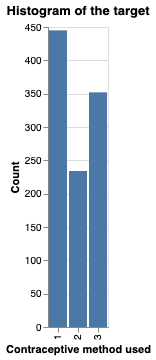

In [5]:
alt.Chart(train_df, title="Histogram of the target").mark_bar().encode(
    x=alt.X("Contraceptive method used", type="ordinal"),
    y=alt.Y("count()", title="Count"),
)

There is a class imbalance problem, but it is not necessary to immediately start our modeling plan with over- or under-sampling. We shall explore the data and create our model first.

# 3. Exploratory Data Analysis

### 3.1 Plot the Histogram of all numerical features

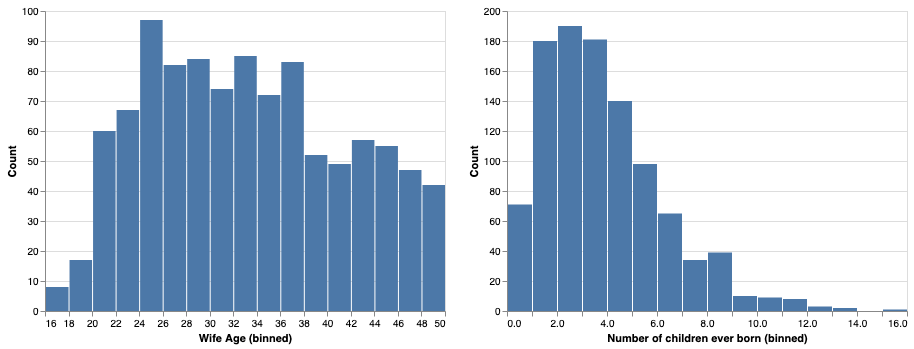

In [6]:
numerical_features = ["Wife Age", "Number of children ever born"]
alt.Chart(train_df).mark_bar().encode(
    x=alt.X(alt.repeat(), type="quantitative", bin=alt.Bin(maxbins=30)),
    y=alt.Y("count()", title="Count"),
).repeat(numerical_features)

Two graphs are skewed to the right. This is expected as there are more young wife than old wife and most people have around two to three kids.

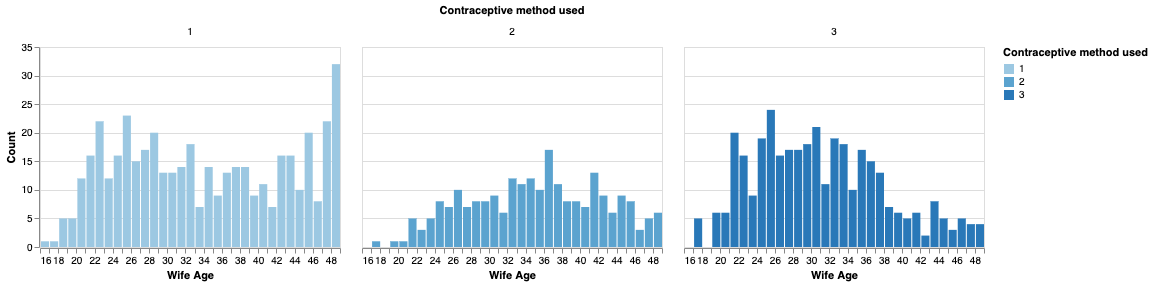

In [7]:
alt.Chart(train_df, title="Distribution of Wife Age by Contraceptive method used").mark_bar().encode(
    x=alt.X("Wife Age:Q", bin=alt.Bin(maxbins=40), title="Wife Age"),
    y=alt.Y("count()", title="Count"),
    color="Contraceptive method used:O",
).properties(width=300, height=200).facet("Contraceptive method used")

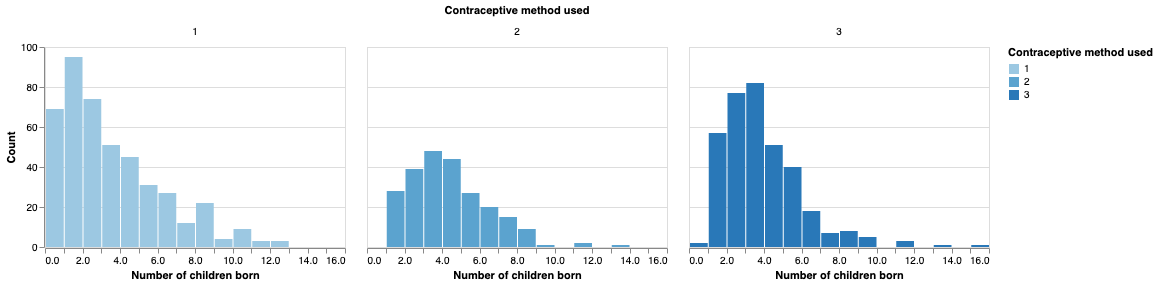

In [8]:
alt.Chart(
    train_df, title="Distribution of number of children by contraceptive method used"
).mark_bar().encode(
    x=alt.X(
        "Number of children ever born",
        title="Number of children born",
        bin=alt.Bin(maxbins=30),
    ),
    y=alt.Y("count()", title="Count"),
    color="Contraceptive method used:O",
).properties(
    width=300, height=200
).facet(
    "Contraceptive method used"
)

### 3.2 Counting combinations of categorical features

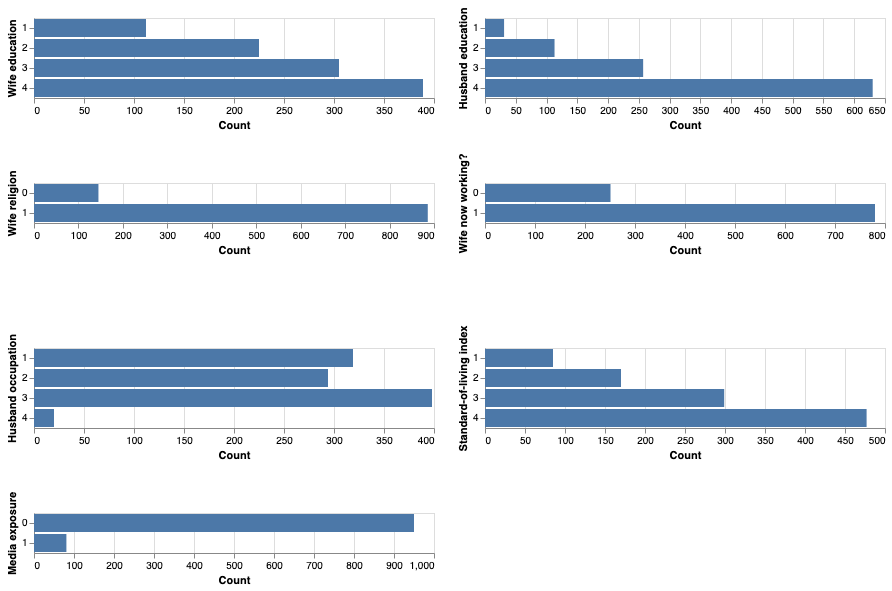

In [9]:
categorical_features = list(train_df.drop(columns=["Wife Age", "Number of children ever born", "Contraceptive method used"]).columns)
alt.Chart(train_df).mark_bar().encode(
    x=alt.X("count()", title="Count"),
    y=alt.Y(alt.repeat(), type="nominal"),
).repeat(categorical_features, columns=2)

Overall, the survey captured women with high levels of education, religious belief, educated partners and living at a high standard of living.

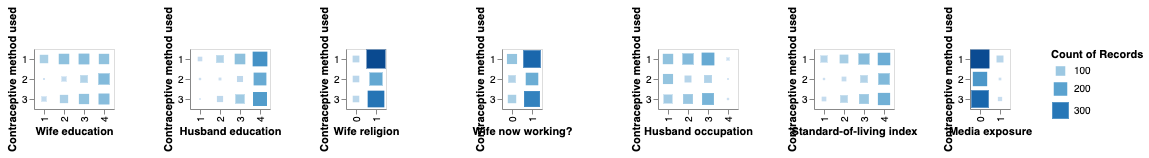

In [10]:
alt.Chart(train_df).mark_square().encode(
    x=alt.X(alt.repeat(), type="nominal"),
    y="Contraceptive method used:O",
    color='count()',
    size='count()'
).repeat(categorical_features)

We spotted that most of the observation by target class 1 (no contraception) lies on certain categorical variables. But since there is class imbalance problem, we cananot imply they are correlated.

### 3.2 Plot the Scatter Plot and Correlation Plot of all features

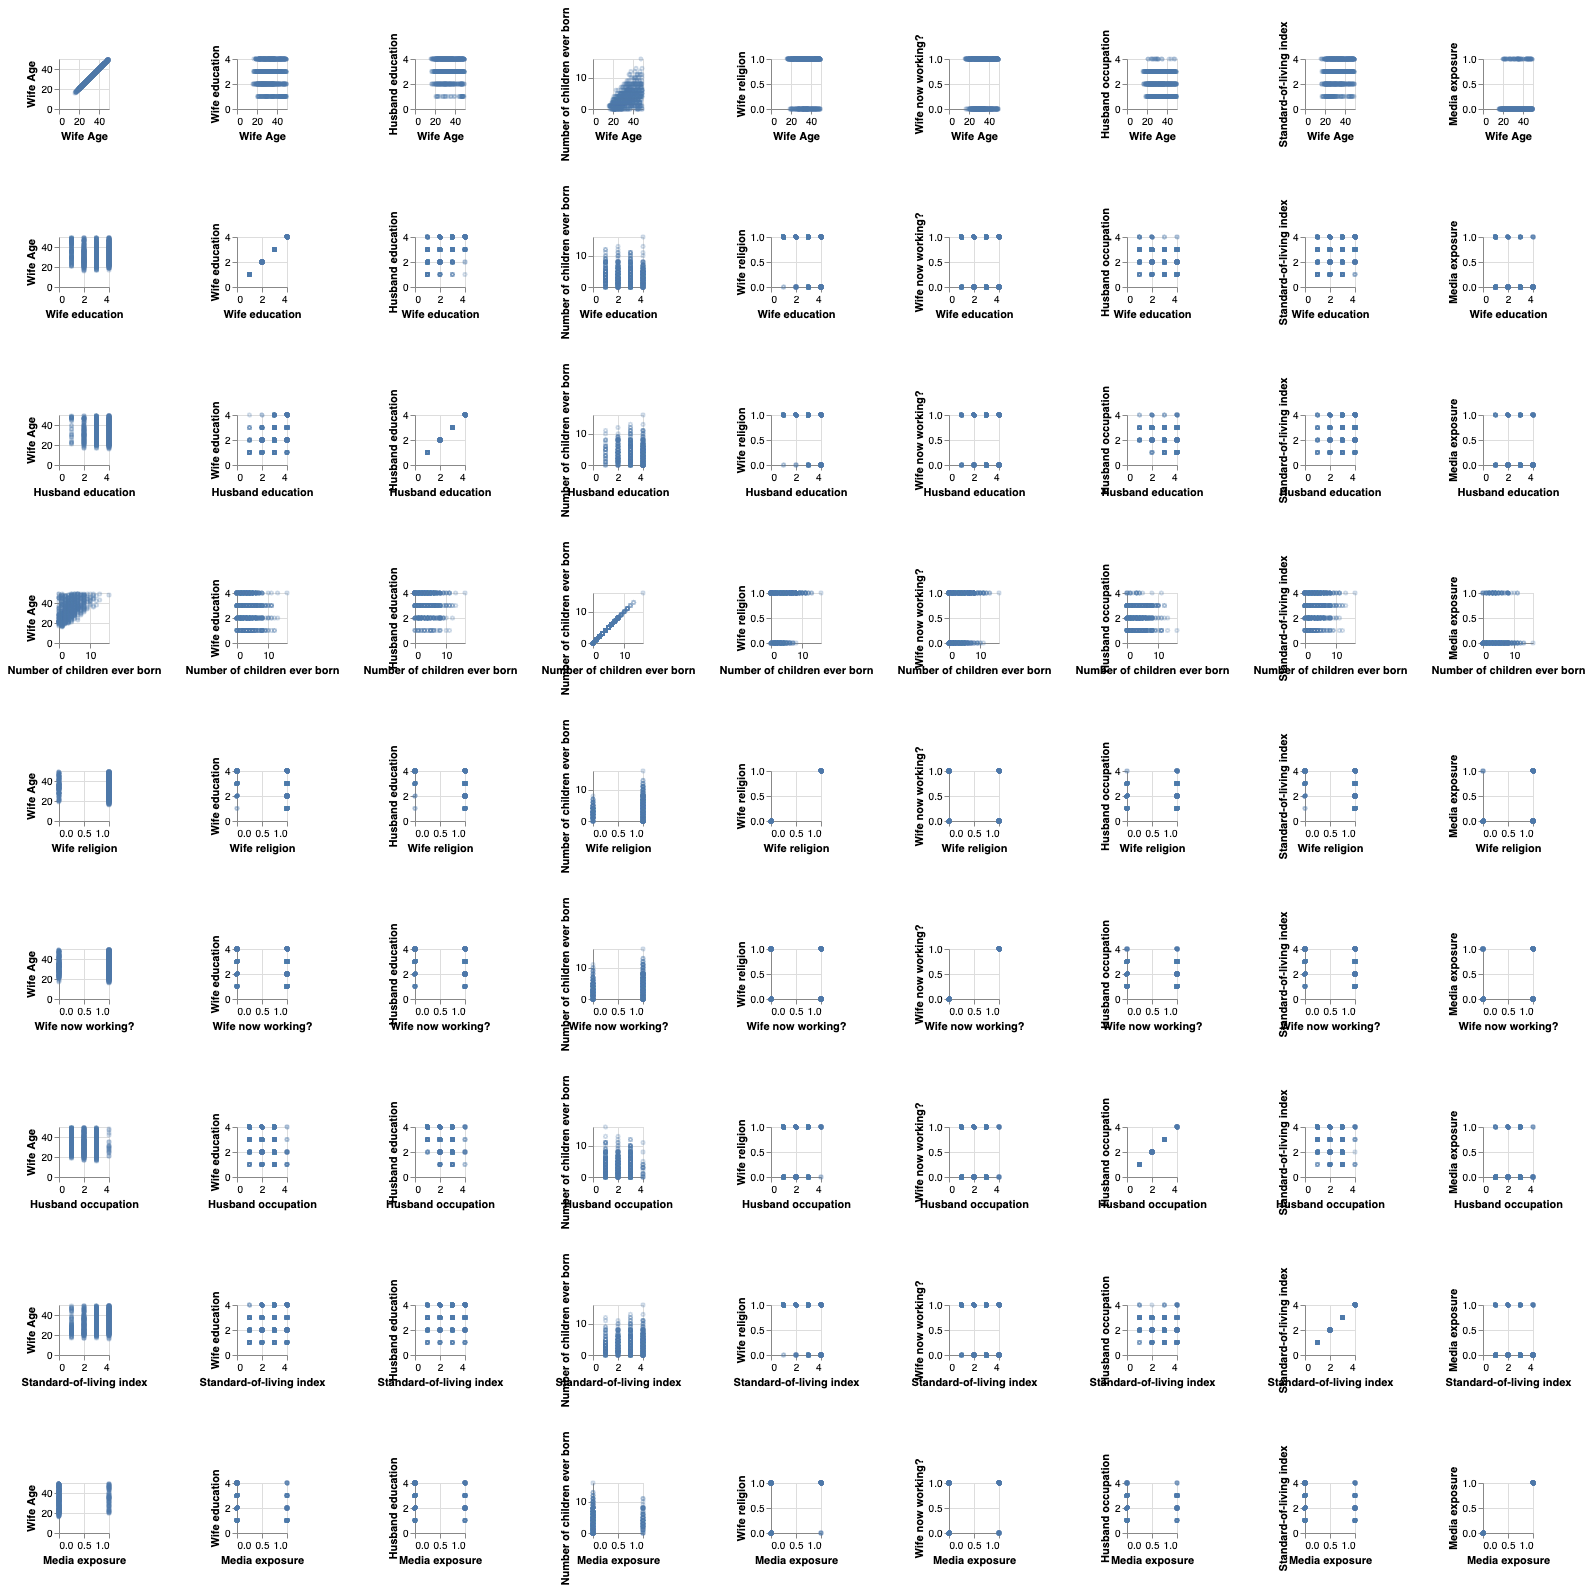

In [11]:
alt.Chart(train_df).mark_point(opacity=0.3, size=10).encode(
    x=alt.X(alt.repeat("row"), type="quantitative"),
    y=alt.Y(alt.repeat("column"), type="quantitative"),
).properties(width=50, height=50).repeat(
    row=list(train_df.drop(columns=["Contraceptive method used"]).columns),
    column=list(train_df.drop(columns=["Contraceptive method used"]).columns),
)

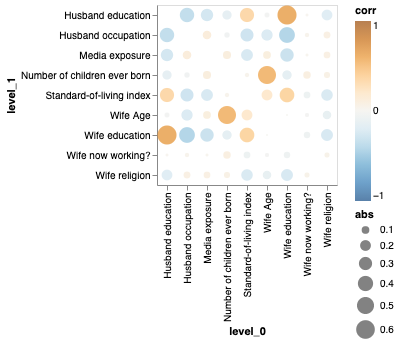

In [12]:
corr_df = (
    train_df.drop(columns=['Contraceptive method used']).select_dtypes("number").corr("spearman").stack().reset_index(name="corr")
)
corr_df.loc[corr_df["corr"] == 1, "corr"] = 0  # Remove diagonal
corr_df["abs"] = corr_df["corr"].abs()
alt.Chart(corr_df).mark_circle().encode(
    x="level_0",
    y="level_1",
    size="abs",
    color=alt.Color("corr", scale=alt.Scale(scheme="blueorange", domain=(-1, 1))),
)

From the plots above, we know that the age of the wife is positively correlated to the number of children ever born and there is also correlation between wife's education and husband's education. Meanwhile, their standard of living index is also correlated to their education.